In [1]:
import sys
import os

import numpy as np
import scipy.optimize as opt
import pandas as pd
from matplotlib import pyplot as plt, animation
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse
import proplot as plot
import seaborn as sns
from tqdm import tqdm

def ancestor_folder_path(current_path, ancestor_folder_name):  
    parent_path = os.path.dirname(current_path)
    if parent_path == current_path:
        raise ValueError("Couldn't find ancestor folder.")
    if parent_path.split('/')[-1] == ancestor_folder_name:
        return parent_path
    return ancestor_folder_path(parent_path, ancestor_folder_name)

sys.path.append(ancestor_folder_path(os.getcwd(), 'accphys'))
from tools import animation as myanim
from tools import beam_analysis as ba
from tools import plotting as myplt
from tools import utils

sys.path.append('..')
from data_analysis import to_vec, to_mat, reconstruct

In [2]:
plot.rc['figure.facecolor'] = 'white'
plot.rc['savefig.dpi'] = 'figure'
plot.rc['animation.html'] = 'jshtml'
plot.rc['grid.alpha'] = 0.04
plot.rc['axes.grid'] = False

save_figures = True

In [3]:
def save(figname):
    if save_figures:
        filename = os.path.join('_output/figures', figname + '.png')
        plt.savefig(filename, facecolor='white', dpi=250)

# 4D Measurement in RTBT
> This notebook reconstructs the beam covariance matrix at the entrance of the Ring to Target Beam Transport (RTBT) section of the Spallation Neutron Source (SNS).

<img src="_input/rtbt.png" width=800>

## Method summary

The goal is to reconstruct the transverse beam covariance matrix at position $s = s_0$:

$$
\Sigma_{0} = \begin{bmatrix}
    \langle{x^2}\rangle & \langle{xx'}\rangle & \langle{xy}\rangle & \langle{xy'}\rangle \\
    \langle{xx'}\rangle & \langle{{x'}^2}\rangle & \langle{yx'}\rangle & \langle{x'y'}\rangle \\
    \langle{xy}\rangle & \langle{yx'}\rangle & \langle{y^2}\rangle & \langle{yy'}\rangle \\
    \langle{xy'}\rangle & \langle{x'y'}\rangle & \langle{yy'}\rangle & \langle{{y'}^2}\rangle
\end{bmatrix}.
$$

To do this, a set of $n$ wire-scanners can be placed at positions $\{s_i\} > s_0$ with $i = 1, ..., n$. A single measurement from wire-scanner $i$ will produce the real-space moments of the beam at $s_i$: $\langle{x^2}\rangle_{i}$, $\langle{y^2}\rangle_{i}$, and $\langle{xy}\rangle_{i}$. Without space charge, the transfer matrix $M_{s_0 \rightarrow s_i} = M_i$ is known. The moments at $s_0$ are then directly related to those at $s_i$ by

$$\Sigma_i = M_i \Sigma_{0} {M_i}^T.$$ This gives <br>

$$
\begin{align}
    \langle{x^2}\rangle_i &= 
        m_{11}^2\langle{x^2}\rangle_{0} 
      + m_{12}^2\langle{x'^2}\rangle_{0} 
      + 2m_{11}m_{22}\langle{xx'}\rangle_{0} ,\\
    \langle{y^2}\rangle_i &= 
        m_{33}^2\langle{y^2}\rangle_{0} 
      + m_{34}^2\langle{y'^2}\rangle_{0} 
      + 2m_{33}m_{34}\langle{yy'}\rangle_{0} ,\\
    \langle{xy}\rangle_i &= 
        m_{11}m_{33}\langle{xy}\rangle_{0} 
      + m_{12}m_{33}\langle{yx'}\rangle_{0} 
      + m_{11}m_{34}\langle{xy'}\rangle_{0} 
      + m_{12}m_{34}\langle{x'y'}\rangle_{0} ,
\end{align}
$$

where $m_{lm}$ are the elements of the transfer matrix. Taking 3 measurements with different optics settings between $s_0$ and $s_i$ (and therefore different transfer matrices) gives the 10 equations necessary to solve for $\Sigma_0$; however, real measurements will be noisy, so it is better to take more measurements if possible. Given $N$ measurements, we can form a $3N \times 1$ observation array $b$ from the measured moments and a $3N \times 10$ coefficient array $A$ from the transfer matrix such that

$$\begin{align} \mathbf{A \sigma}_0 = \mathbf{b},\end{align}$$ 

where $\mathbf{\sigma}_0$ is a $10 \times 1$ vector of the moments at $s_0$. There are 5 wire-scanners in the RTBT which operate simultaneously, so if all these are used the coefficient array will be $15N \times 10$. We then choose $\mathbf{\sigma}_0$ such that $|\mathbf{A\sigma}_0 - \mathbf{b}|^2$ is minimized:

$$ \mathbf{\sigma}_0 = (\mathbf{A}^T\mathbf{A})^{-1}\mathbf{A}^T\mathbf{b} $$

## RTBT lattice functions 

In [4]:
twiss = pd.read_csv('_output/data/twiss.dat')
ws_positions = np.loadtxt('_output/data/ws_positions.dat')

In [5]:
# fig, axes = plot.subplots(nrows=3, figsize=(6, 5), spany=False)
# for scan_index in range(1, 6):
#     twiss_df = pd.read_csv('_output/data/twiss_{}.dat'.format(scan_index))
#     twiss_df[['s','bx','by']].plot('s', ax=axes[0], legend=False)
#     twiss_df[['s','ax','ay']].plot('s', ax=axes[1], legend=False)
#     twiss_df[['s','nux','nuy']].plot('s', ax=axes[2], legend=False)
#     axes.format(cycle='colorblind')
# axes.format(xlabel='s [m]', toplabels='RTBT lattice functions', grid=False)
# for ax, ylabel in zip(axes, [r'$\beta$ [m]', r'$\alpha$ [rad]', 'Frac. phase / ($2\pi$)']):
#     ax.format(ylabel=ylabel);
#     for ws_position in ws_positions:
#         ax.axvline(ws_position, color='grey', ls='--', lw=0.5, alpha=0.5, zorder=0)
# axes[0].legend(labels=['x', 'y', 'wire-scanner'], ncols=1, loc=(1.02, 0));
# save('twiss_scan')

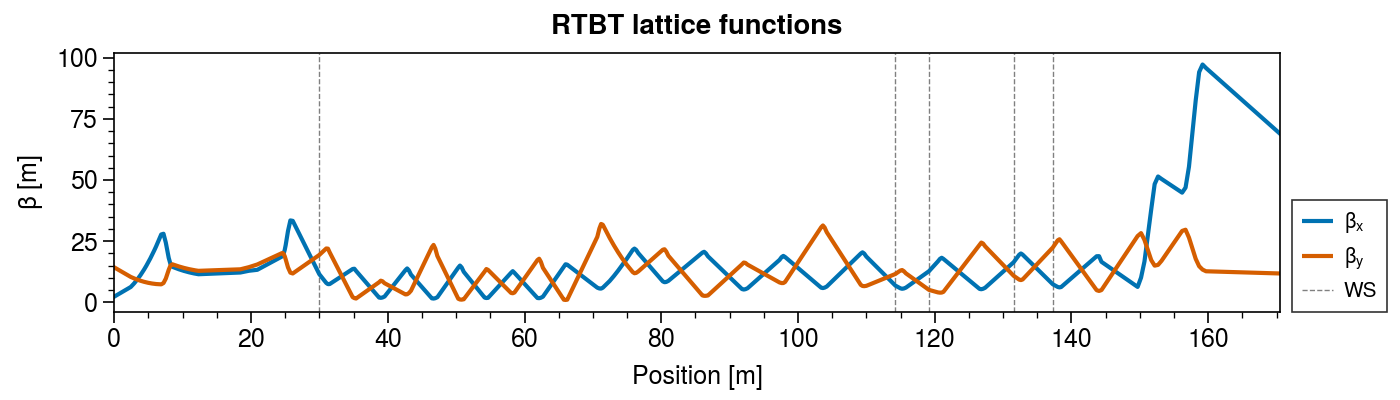

In [6]:
fig, ax = plot.subplots(figsize=(7, 2))
twiss[['s','bx','by']].plot('s', ax=ax, legend=False)
ax.format(xlabel='Position [m]', ylabel=r'$\beta$ [m]', toplabels='RTBT lattice functions')
for ws_position in ws_positions:
    ax.axvline(ws_position, color='grey', ls='--', lw=0.5, zorder=0)
ax.format(xlim=(0, twiss['s'].max()))
ax.legend(labels=[r'$\beta_x$', r'$\beta_y$', 'WS'], 
          ncols=1, loc=(1.01, 0), handlelength=1.5, fontsize='small')
plt.savefig('_output/figures/beta.png', facecolor='white', dpi=250)

## Phase scan

In [12]:
ws_names = ['ws02', 'ws20', 'ws21', 'ws23', 'ws24']
active_ws_names = ws_names[1:]

In [13]:
def load(filename, ws_name):
    path = '_output/data/{}/{}'.format(ws_name, filename)
    return np.load(path)

phases_dict, moments_dict, transfer_mats_dict = dict(), dict(), dict()
for ws_name in ws_names:
    phases_dict[ws_name] = load('phases.npy', ws_name)
    moments_dict[ws_name] = load('moments.npy', ws_name)
    transfer_mats_dict[ws_name] = load('transfer_mats.npy', ws_name)
    
phases_list, moments_list, transfer_mats_list = [], [], []
for ws_name in ws_names:
    phases_list.extend(phases_dict[ws_name])
    moments_list.extend(moments_dict[ws_name])
    transfer_mats_list.extend(transfer_mats_dict[ws_name])

In [14]:
Sigma0 = np.loadtxt('_output/data/Sigma0.dat')
Sigma0 *= 1e6 # convert to [mm mrad]
X0 = np.loadtxt('_output/data/X0.dat')
X0 *= 1e3 # convert to [mm mrad]

Observe the beam at the wire-scanners. Any greyed-out wire-scanners are not used in the reconstruction.

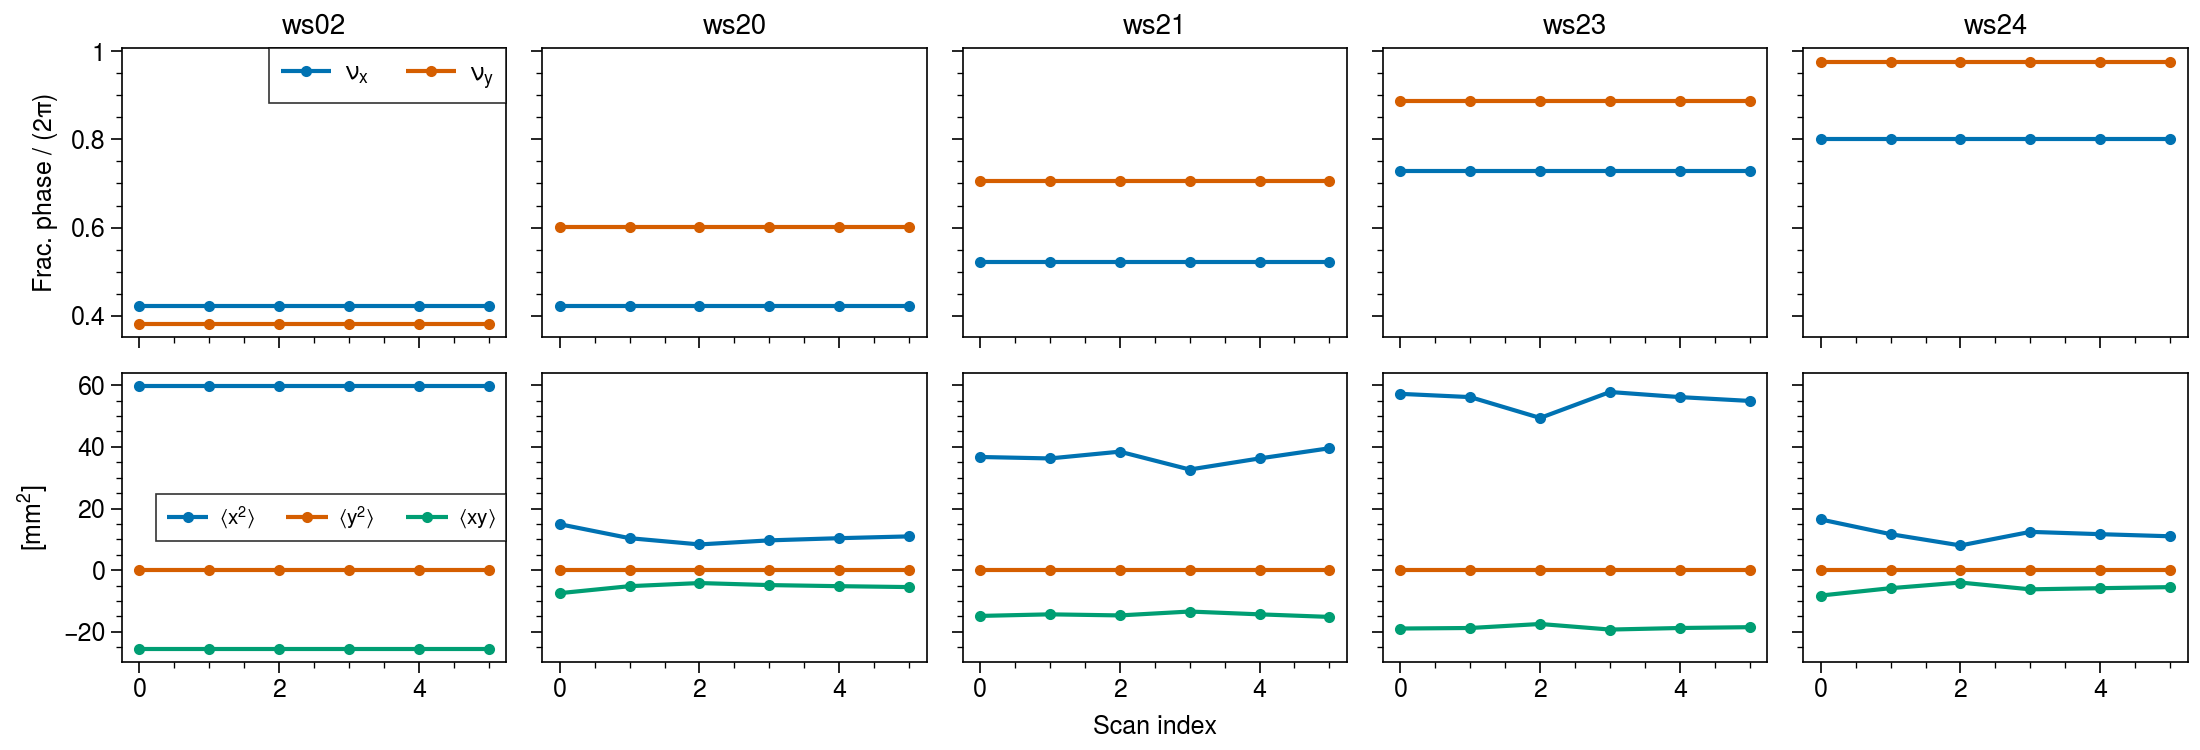

In [15]:
fig, axes = plot.subplots(nrows=2, ncols=5, figsize=(11, 3.75), spany=False)
plt_kws = dict(marker='.')
for ax, ws_name in zip(axes[0, :], ws_names):
    ax.plot(phases_dict[ws_name] % 1, **plt_kws)
    ax.set_title(ws_name)
for ax, ws_name in zip(axes[1, :], ws_names):
    ax.plot(moments_dict[ws_name][:, 0], **plt_kws)
    ax.plot(moments_dict[ws_name][:, 1], **plt_kws)
    ax.plot(moments_dict[ws_name][:, 2], **plt_kws)
axes[0, 0].legend(labels=[r'$\nu_x$', r'$\nu_y$'], ncols=3);
axes[1, 0].format(ylabel='[mm$^2$]')
axes[1, 0].legend(labels=[r'$\langle{x^2}\rangle$', r'$\langle{y^2}\rangle$', r'$\langle{xy}\rangle$'], fontsize='small');
axes[0, 0].format(ylabel='Frac. phase / ($2\pi$)', xlabel='Scan index')
save('ws_phase_adv')

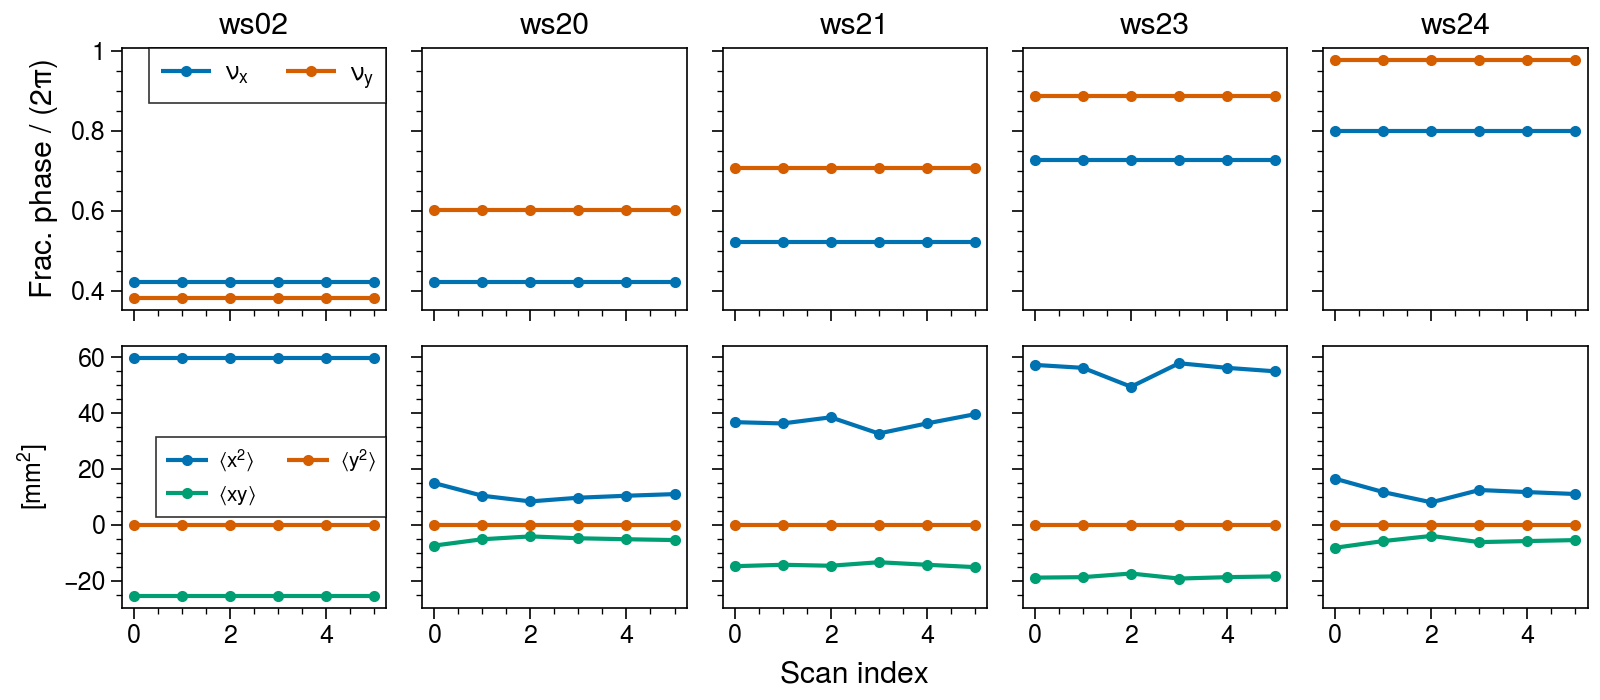

In [17]:
fig, axes = plot.subplots(nrows=2, ncols=5, figsize=(8, 3.5), spany=False)
for ax, ws_name in zip(axes[0, :], ws_names):
    ax.plot(phases_dict[ws_name] % 1, **plt_kws)
    ax.set_title(ws_name, fontsize='large')
for ax, ws_name in zip(axes[1, :], ws_names):
    ax.plot(moments_dict[ws_name][:, 0], **plt_kws)
    ax.plot(moments_dict[ws_name][:, 1], **plt_kws)
    ax.plot(moments_dict[ws_name][:, 2], **plt_kws)
axes[0, 0].legend(labels=[r'$\nu_x$', r'$\nu_y$'], ncols=3);
axes[1, 0].format(ylabel='[mm$^2$]')
axes[1, 0].legend(labels=[r'$\langle{x^2}\rangle$', r'$\langle{y^2}\rangle$', r'$\langle{xy}\rangle$'], fontsize='small', ncols=2);
axes[0, 0].format(ylabel='Frac. phase / ($2\pi$)', xlabel='Scan index', xlabel_kw={'size':'large'}, ylabel_kw={'size':'large'})
plt.savefig('_output/figures/ws_phase_adv.png', facecolor='white', dpi=350)

To do: 
* Add column below showing phase vs scan index.
* Add diagonal line at angle of diagonal wire.

In [ ]:
# dims = ('x', 'y')

In [18]:
# str_to_int = {'x':0, 'xp':1, 'y':2, 'yp':3}
# i, j = [str_to_int[dim] for dim in dims]

# ell_coords_list = [[ba.get_ellipse_coords(env_params) for env_params in env_params_dict[ws]] 
#                    for ws in ws_ids]
# ell_coords_list = np.array(ell_coords_list)

# pad = 0.25
# limits_list = np.array([(1 + pad) * myplt.max_u_up_global(coords) 
#                         for coords in ell_coords_list])
# umax, upmax = np.max(limits_list, axis=0)
# limits = 2 * [(-umax, umax), (-upmax, upmax)]
# labels = ['x [mm]', "x' [mrad]", 'y [mm]', "y' [mrad]"]

# fig, ax_list = plt.subplots(ncols=6, figsize=(13, 1.75), sharex=True, sharey=True)
# axes, text_ax = ax_list[:-1], ax_list[-1]
# text_ax.grid(False)
# myplt.despine([text_ax], 'all')
# myplt.despine(axes)
# axes[0].set_xlim(limits[i])
# axes[0].set_ylim(limits[j])
# axes[0].set_yticks(axes[0].get_xticks())
# axes[0].set_xlabel(labels[i])
# axes[0].set_ylabel(labels[j])
# for ax, ws_name in zip(axes, ws_ids):
#     ax.set_title(ws_name, color='grey' if ws_name not in active_ws_ids else 'k')
#     ax.grid(False)
#     ax.axvline(0, lw=0.2, c='k', alpha=0.2, zorder=99)
#     ax.axhline(0, lw=0.2, c='k', alpha=0.2, zorder=99)
# plt.close()

# def update(t):
#     for ax, coords in zip(axes, ell_coords_list):
#         for patch in ax.patches:
#             patch.remove()
#         ax.fill(coords[t, :, i], coords[t, :, j], fc='lightsteelblue', ec='k', zorder=10)
#     for ws, ax in zip(ws_ids, axes):
#         nux, nuy = phases_dict[ws][t]
#         for text in ax.texts:
#             text.set_visible(False)
#         ax.annotate(r'$\nu_x = {:.2f}$'.format(nux), xy=(0.75, 0.85), xycoords='axes fraction', zorder=10)
#         ax.annotate(r'$\nu_y = {:.2f}$'.format(nuy), xy=(0.75, 0.75), xycoords='axes fraction', zorder=10)
#     for text in text_ax.texts:
#         text.set_visible(False)
#     text_ax.annotate('Scan index = {}'.format(t), xy=(0.25, 0.5), xycoords='axes fraction', horizontalalignment='center')

# nframes = ell_coords_list[0].shape[0]
# fps = 1
# anim = animation.FuncAnimation(fig, update, frames=nframes, interval=1000/fps)
# if save_figures:
#      anim.save('_output/figures/ws_envelope.mp4', dpi=300)
# anim

In [19]:
# for ws in ws_ids:
#     print(ws)
#     anim = myanim.corner_env(env_params_dict[ws], figsize=(4, 4), text_fmt='Scan index = {}')
#     play(anim)

In [20]:
# myplt.corner(X0, moments=True, text='Initial bunch');
# save('initial_dist')

## Reconstruction

   Iteration        Cost      Cost reduction    Step norm     Optimality   
       0         3.5254e+03                                    1.88e+03    
       1         2.8176e+03      7.08e+02       7.70e-02       4.71e+02    
       2         2.6406e+03      1.77e+02       4.38e-02       1.18e+02    
       3         2.5964e+03      4.42e+01       2.19e-02       2.94e+01    
       4         2.5853e+03      1.11e+01       1.09e-02       7.35e+00    
       5         2.5826e+03      2.76e+00       5.47e-03       1.84e+00    
       6         2.5819e+03      6.91e-01       2.74e-03       4.60e-01    
       7         2.5817e+03      1.73e-01       1.37e-03       1.15e-01    
       8         2.5817e+03      4.32e-02       6.84e-04       2.87e-02    
       9         2.5817e+03      1.08e-02       3.42e-04       7.18e-03    
      10         2.5817e+03      2.70e-03       1.71e-04       1.80e-03    
      11         2.5817e+03      6.75e-04       8.55e-05       4.49e-04    
      12    

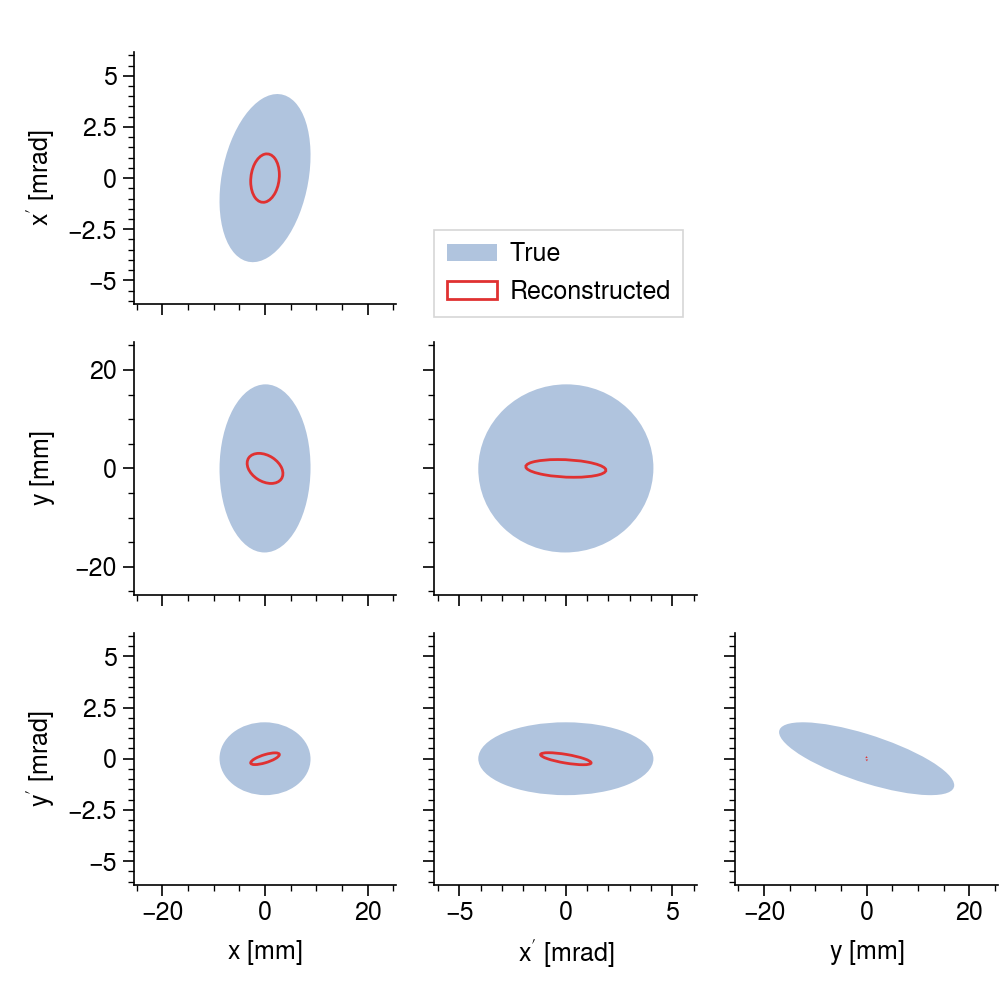

In [22]:
Sigma = reconstruct(transfer_mats_list, moments_list, verbose=2)
print()
utils.show(Sigma, 'Sigma')
print()
Sigma0 *= 1e-6
utils.show(Sigma0, 'Sigma0')
print()
utils.show(Sigma - Sigma0, 'Sigma - Sigma0')

axes = myplt.rms_ellipses(Sigma0, color='lightsteelblue', fill=True, lw=0);
axes = myplt.rms_ellipses(Sigma, axes=axes, color='red8', lw=1)
axes[1, 1].legend(labels=['True', 'Reconstructed'], loc=(0, 1.1))
save('projection_default')

## Visualization using lines

In [23]:
ax0, ay0, bx0, by0 = [-0.25897, 0.9749, 2.2991, 14.2583]
ex, ey = ba.apparent_emittances(Sigma0)

def V_2D(alpha, beta):
    return np.array([[beta, 0.0], [-alpha, 1.0]]) / np.sqrt(beta)

V = np.zeros((4, 4))
V[:2, :2] = V_2D(ax0, bx0)
V[2:, 2:] = V_2D(ay0, by0)
Vinv = np.linalg.inv(V)

def normalize(vec):
    return np.matmul(Vinv, vec)

scale = 2
xmax = scale * np.sqrt(ex)
ymax = scale * np.sqrt(ey)

In [24]:
def get_line_points(M, sig_xx, sig_yy, dim, upmin=-10, upmax=10):
    xrms, yrms = np.sqrt(sig_xx), np.sqrt(sig_yy)
    hpts, vpts = [], []
    for up in [upmin, upmax]:
        if dim == 'x':
            vec1 = [xrms, up, 0, 0]
            i, j = 0, 1
        elif dim == 'y':
            vec1 = [0, 0, yrms, up]
            i, j = 2, 3
        vec0 = np.matmul(np.linalg.inv(M), vec1)
        vec0 = normalize(vec0)
        hpts.append(vec0[i])
        vpts.append(vec0[j])
    return hpts, vpts

def plot_lines(ax, transfer_mats, moments, dim='x', **kws):  
    for transfer_mat, (sig_xx, sig_yy, sig_xy) in zip(transfer_mats, moments):
        hpts, vpts = get_line_points(transfer_mat, sig_xx, sig_yy, dim)
        ax.plot(hpts, vpts, **kws)
    return ax

NameError: name 'ws_ids' is not defined

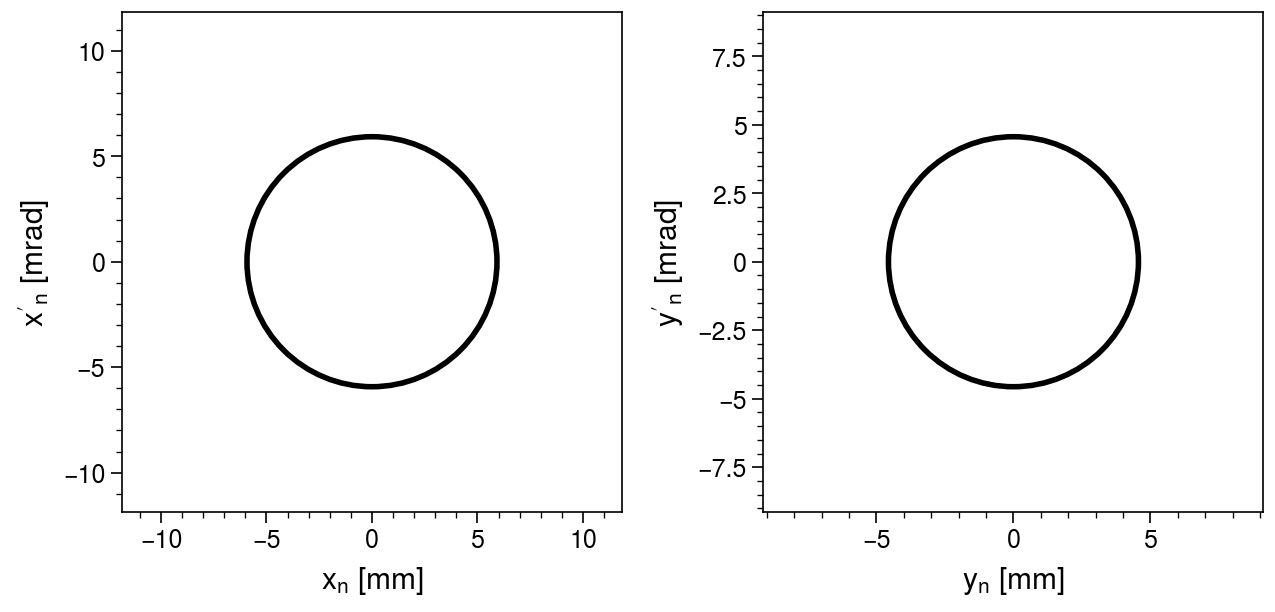

In [25]:
fig, axes = plot.subplots(ncols=2, sharex=False, sharey=False)
axes.format(aspect=1)
axes[0].format(xlim=(-xmax, xmax), ylim=(-xmax, xmax), xlabel=r"$x_n$ [mm]", ylabel=r"$x'_n$ [mrad]")
axes[1].format(xlim=(-ymax, ymax), ylim=(-ymax, ymax), xlabel=r"$y_n$ [mm]", ylabel=r"$y'_n$ [mrad]")
axes.format(xlabel_kw=dict(fontsize='large'), ylabel_kw=dict(fontsize='large'))
myplt.ellipse(axes[0], np.sqrt(ex), np.sqrt(ex), lw=2, zorder=0)
myplt.ellipse(axes[1], np.sqrt(ey), np.sqrt(ey), lw=2, zorder=0)

ws_ids_new_order = ws_ids[1:] + [ws_ids[0]]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(ws_ids)]
for ws_id, color in zip(ws_ids_new_order, colors):
    kws = dict(lw=1, color=color)
    plot_lines(axes[0], transfer_mats_dict[ws_id], moments_dict[ws_id], 'x', **kws)
    plot_lines(axes[1], transfer_mats_dict[ws_id], moments_dict[ws_id], 'y', **kws)
custom_lines = [Line2D([0], [0], color=color) for color in colors]
axes[1].legend(custom_lines, ws_ids_new_order, ncols=1, loc=(1.02, 0))
save('lines')

In [ ]:
# fig, axes = plot.subplots(ncols=2, sharex=False, sharey=False)
# axes.format(aspect=1)
# axes[0].format(xlim=(-xmax, xmax), ylim=(-xmax, xmax), xlabel=r"$x_n$ [mm]", ylabel=r"$x'_n$ [mrad]")
# axes[1].format(xlim=(-ymax, ymax), ylim=(-ymax, ymax), xlabel=r"$y_n$ [mm]", ylabel=r"$y'_n$ [mrad]")
# myplt.ellipse(axes[0], np.sqrt(ex), np.sqrt(ex), lw=2, zorder=999)
# myplt.ellipse(axes[1], np.sqrt(ey), np.sqrt(ey), lw=2, zorder=999)
# plt.close()

# def update(i):
#     plot_lines(axes[0], transfer_mats[:i+1], moments[:i+1], dim='x', color='pink9')
#     plot_lines(axes[1], transfer_mats[:i+1], moments[:i+1], dim='y', color='pink9')
    
# animation.FuncAnimation(fig, update, frames=len(transfer_mats))